In [1]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import numpy as np
from sklearn import *
from scipy import stats
np.random.seed(100)
import csv
from scipy import io
import pickle
from pathlib import Path
from IPython.display import Audio, display, Image
import os.path

In [2]:
import librosa
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import gc
import joblib
import os
import warnings
warnings.filterwarnings('ignore')
import logging

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torchaudio
import torchvision
import torch
print('PyTorch version:{}, Device:{}'.format(torch.__version__, torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

PyTorch version:1.13.0, Device:cuda


In [4]:
seed_value = 46

np.random.seed(seed_value)

torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
class Config:
    seed = 46
    n_fft = 2048
    duration = 5
    sr = 32000
    hop_length = 512
    fmin = 20
    fmax = 12000
    n_mels = 128
    n_mfcc = 20

    n_fold = 5
    n_class = 264
    df_path = Path('dfdata')
    mel_dir = Path('train_mel')
    model_dir = Path('effmodel')
    
    batch_size = 32
    num_workers = 2
    device = torch.device('cuda')
    epochs = 12
    PRECISION = 16    
    PATIENCE = 8    
    pretrained = True            
    weight_decay = 1e-3
    lr = 0.0005
    mix_up_alpha = 0.2

In [6]:
Config.mel_dir.mkdir(exist_ok=True, parents=True)
Config.df_path.mkdir(exist_ok=True, parents=True)
Config.model_dir.mkdir(exist_ok=True, parents=True)

In [7]:
def padded_cmap_metrics(solution, submission, padding_factor=5):
    # solution = solution.drop(['row_id'], axis=1, errors='ignore')
    # submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

def LR_AP(solution, submission):
    score = metrics.label_ranking_average_precision_score(solution, submission)
    return score

def AUC(solution, submission):
    score = metrics.roc_auc_score(solution, submission)
    return score

In [8]:
df_meta = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')
df_meta.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg


In [9]:
len(df_meta.columns)

12

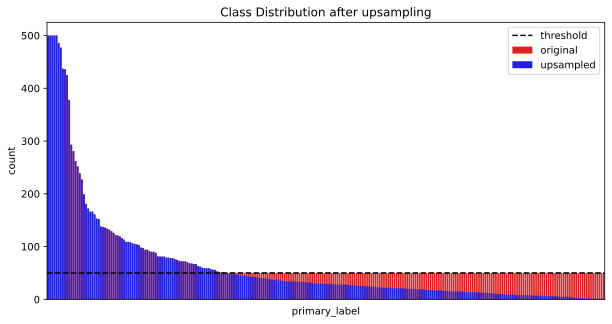

In [10]:
thr = 50
class_dist = df_meta['primary_label'].value_counts()

down_classes = class_dist[class_dist < thr].index.tolist()

up_list = []
for label in down_classes:
        class_df = df_meta[df_meta['primary_label'] == label]
        num_up = thr - class_df.shape[0]
        class_df = class_df.sample(n=num_up, replace=True, random_state=46)
        up_list.append(class_df)

upsample_df = pd.concat([df_meta] + up_list, axis=0, ignore_index=True)
upsample_df['primary_label_id'] = upsample_df['primary_label'].factorize()[0]
upsample_df['unique_id'] = upsample_df.index.tolist()

plt.figure(figsize=(10, 5))
sns.countplot(x='primary_label', data=upsample_df, order=upsample_df['primary_label'].value_counts().index, color='red', label='original')
sns.countplot(x='primary_label', data=df_meta, order=df_meta['primary_label'].value_counts().index, color='blue', label='upsampled')
plt.axhline(y=50, color='k', linestyle='--', label='threshold')
plt.xticks([])
plt.title('Class Distribution after upsampling')
plt.legend()
plt.show()

In [11]:
train_df, test_df = model_selection.train_test_split(upsample_df, test_size=0.2, random_state=46, stratify=upsample_df['primary_label'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [12]:
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=46)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['primary_label'])):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(int)

In [13]:
#primary label add second label into multilabel
train_df['secondary_labels'] = train_df['secondary_labels'].apply(lambda x: x[1:-1].split(','))
# remove the token in each item
train_df['secondary_labels'] = train_df['secondary_labels'].apply(lambda x: [i[1:-1] for i in x])
train_df['secondary_labels'] = train_df['secondary_labels'].apply(lambda x: [i.replace('\'','') for i in x])
train_df['secondary_labels'] = train_df['secondary_labels'].apply(lambda x: [i for i in x if i != ''] )
train_df_multi_labels = train_df.apply(lambda x: [x['primary_label']] + x['secondary_labels'], axis=1)

train_onehot_list = []
label_list = df_meta['primary_label'].unique().tolist()
for i in tqdm(range(len(train_df))):
    one_hot = [0]*len(label_list)
    for j in train_df_multi_labels[i]:
        one_hot[label_list.index(j)] = 1
    train_onehot_list.append(one_hot)

test_df['secondary_labels'] = test_df['secondary_labels'].apply(lambda x: x[1:-1].split(','))
# remove the token in each item
test_df['secondary_labels'] = test_df['secondary_labels'].apply(lambda x: [i[1:-1] for i in x])
test_df['secondary_labels'] = test_df['secondary_labels'].apply(lambda x: [i.replace('\'','') for i in x])
test_df['secondary_labels'] = test_df['secondary_labels'].apply(lambda x: [i for i in x if i != ''] )
test_df_multi_labels = test_df.apply(lambda x: [x['primary_label']] + x['secondary_labels'], axis=1)
test_onehot_list = []
for i in tqdm(range(len(test_df))):
    one_hot = [0]*len(label_list)
    for j in test_df_multi_labels[i]:
        one_hot[label_list.index(j)] = 1
    test_onehot_list.append(one_hot)

  0%|          | 0/17766 [00:00<?, ?it/s]

  0%|          | 0/4442 [00:00<?, ?it/s]

In [14]:
train_onehot_df = pd.DataFrame(train_onehot_list, columns=label_list)
train_df = pd.concat([train_df, train_onehot_df], axis=1)
train_df.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,colsun2,[],"['alarm call', 'male']",-33.4733,26.9505,Hedydipna collaris,Collared Sunbird,Tim Cockcroft,Creative Commons Attribution-NonCommercial-Sha...,4.5,...,0,0,0,0,0,0,0,0,0,0
1,eubeat1,[],['call'],-26.4210,26.3612,Merops apiaster,European Bee-eater,Tony Archer,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,0,0,0,0,0,0,0,0,0,0
2,eubeat1,[],[''],17.9021,42.3810,Merops apiaster,European Bee-eater,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,5.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test_onehot_df = pd.DataFrame(test_onehot_list, columns=label_list)
test_df = pd.concat([test_df, test_onehot_df], axis=1)
test_df.head(3)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,yespet1,[],"['adult', 'alarm call', 'sex uncertain']",-2.9858,37.5975,Gymnoris pyrgita,Yellow-spotted Bush Sparrow,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,5.0,...,0,0,0,0,0,0,0,1,0,0
1,hamerk1,[],[''],18.2116,42.4867,Scopus umbretta,Hamerkop,David Darrell-Lambert,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,0,0,0,0,0,0,0,0,0,0
2,witswa1,[],['call'],19.3642,98.9563,Hirundo smithii,Wire-tailed Swallow,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
upsample_df.to_csv(Config.df_path/'upsample_df.csv', index=False)
train_df.to_csv(Config.df_path/'train_df.csv', index=False)
test_df.to_csv(Config.df_path/'test_df.csv', index=False)
print('finish dataframe store')

finish dataframe store


In [17]:
def pad4mel(y, length, pad_mode='constant'):
    repeat = length // len(y) + 1
    y = np.tile(y, repeat)
    if len(y) < length:
        y = np.pad(y, (0, length - len(y)), pad_mode)
    elif len(y) > length:
        y = y[:length]

    return y

In [18]:
class SaveMelSpectrom:
    def __init__(self, sr=Config.sr, n_mels=128,n_fft=Config.n_fft,hop_length=Config.hop_length, fmin=Config.fmin, fmax=Config.fmax, duration=Config.duration, resample=False):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.duration = duration
        self.fix_audio_length = self.duration*self.sr
        self.resample = resample
        self.crop_length = duration*sr//hop_length+1
        self.shape = (128, self.crop_length)
        

    def getMelSpectrogram(self, wav):
        S = librosa.feature.melspectrogram(y=wav, sr=self.sr,n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax)
        S_dB = librosa.power_to_db(S, ref=np.max)
        return S_dB

    def __call__(self, row, save=True):
        audio_path = '/kaggle/input/birdclef-2023/train_audio/'
        wav, sr = librosa.load(audio_path+row.filename, sr=32000)

        if self.resample and sr != self.sr:
            wav = librosa.resample(wav, sr, self.sr)
        sample_rate = self.sr
        num_frames = len(wav)
        audio_duration = num_frames/sample_rate
        if audio_duration < self.duration:
            wav = pad4mel(wav, self.fix_audio_length)
        mel_data = self.getMelSpectrogram(wav)
        audio_length = audio_duration
        cat_point = np.random.randint(0, max(1, audio_length-self.duration-2))
        cat_index = int(cat_point*self.sr/self.hop_length)
        mel_data = mel_data[:, cat_index:cat_index+self.crop_length]
        
        save_filename = Config.mel_dir/f"{row.filename}".replace('.ogg', '.npy')
        print(save_filename)
#         mel_path = Config.mel_dir +row.filename.split('/')[0]
        if save:
            save_filename.parent.mkdir(exist_ok=True, parents=True)
            np.save(str(save_filename), mel_data)

In [19]:
def save_meldataset(df:pd.DataFrame):
    pool = joblib.Parallel(2)
    converter = SaveMelSpectrom()
    mapper = joblib.delayed(converter)
    tasks = [mapper(row) for row in df.itertuples(False)]
    pool(tqdm(tasks))

In [20]:
save_meldataset(df_meta)
print('finish store mel data')

  0%|          | 0/16941 [00:00<?, ?it/s]

train_mel/abethr1/XC128013.npy
train_mel/abethr1/XC363503.npy
train_mel/abethr1/XC379322.npy
train_mel/abethr1/XC432639.npy
train_mel/abethr1/XC467121.npy
train_mel/abethr1/XC585802.npy
train_mel/abethr1/XC616997.npy
train_mel/abethr1/XC756300.npy
train_mel/abhori1/XC120250.npy
train_mel/abhori1/XC127317.npy
train_mel/abhori1/XC127318.npy
train_mel/abhori1/XC132733.npy
train_mel/abhori1/XC153687.npy
train_mel/abhori1/XC153689.npy
train_mel/abhori1/XC186252.npy
train_mel/abhori1/XC196120.npy
train_mel/abhori1/XC196761.npy
train_mel/abhori1/XC200793.npy
train_mel/abhori1/XC200797.npy
train_mel/abhori1/XC201222.npy
train_mel/abhori1/XC206017.npy
train_mel/abhori1/XC240626.npy
train_mel/abhori1/XC247350.npy
train_mel/abhori1/XC247351.npy
train_mel/abhori1/XC255209.npy
train_mel/abhori1/XC288640.npy
train_mel/abhori1/XC316920.npy
train_mel/abhori1/XC329476.npy
train_mel/abhori1/XC331499.npy
train_mel/abhori1/XC348440.npy
train_mel/abhori1/XC354453.npy
train_mel/abhori1/XC361351.npy
train_me

In [21]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(self, df:pd.DataFrame, sr = Config.sr, duration = Config.duration, hop_length=Config.hop_length, train_val=True):

        self.df = df
        self.sr = sr 
        self.train_val = train_val
        self.duration = duration
        self.hop_length = hop_length
        self.data_dir = Config.mel_dir
#         self.crop_length = duration*sr//hop_length+1
#         self.shape = (128, self.crop_length)

    def __len__(self):
        return len(self.df)

    @staticmethod
    def normalize(mel_spectrogram):
        mel_spectrogram = torch.nn.functional.normalize(mel_spectrogram, p=2, dim=0)
        return mel_spectrogram

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        mel_path = self.data_dir/f"{row.filename}".replace('.ogg', '.npy')
        mel_data = np.load(str(mel_path))
        mel_data = torch.tensor(mel_data).float()
        mel_data = self.normalize(mel_data)
        if self.train_val:
            return mel_data, torch.tensor(row[15:]).float()
        else:
            return mel_data, torch.tensor(row[14:]).float()

In [22]:
test_meldataset = BirdDataset(test_df, train_val=False)
test_loader = torch.utils.data.DataLoader(test_meldataset, batch_size=Config.batch_size, shuffle=False)

In [23]:
tmp_train_meldataset = BirdDataset(train_df[train_df['fold']!=3])
tmp_val_meldataset = BirdDataset(train_df[train_df['fold']==3])
tmp_train_loader = torch.utils.data.DataLoader(tmp_train_meldataset, batch_size=Config.batch_size, shuffle=True)
tmp_val_loader = torch.utils.data.DataLoader(tmp_val_meldataset, batch_size=Config.batch_size, shuffle=False)

In [24]:
def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        'scheduler': lr_scheduler
    }

def evaluate(history, solution, prediction, loss, phase):
    solution = np.concatenate(solution, axis=0)
    prediction = np.concatenate(prediction, axis=0)
    cmAP = padded_cmap_metrics(pd.DataFrame(solution), pd.DataFrame(prediction))
    AP_score = LR_AP(solution, prediction)
    history[phase+'_cmAP'].append(cmAP)
    history[phase+'_LRAP'].append(AP_score)
    history[phase+'_loss'].append(np.mean(loss))
    return history

def process_log(logger, save_path):
    logger.setLevel(logging.DEBUG)
    file_handler = logging.FileHandler(save_path)
    file_handler.setLevel(logging.DEBUG)

    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    return logger


def trans_data():
    transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])
    return transform

In [25]:
def each_step_train_model(model, criterion, transform, optimizer_dict, train_dl, channel_num=1, aug=False):
    history = {'train_loss': [], 'val_loss': [], 'train_cmAP': [], 'val_cmAP': [], 'train_LRAP': [], 'val_LRAP': []}
    train_loss = []
    train_solution = []
    train_prediction = []
    model.train()
    for i, (inputs, labels) in enumerate(train_dl):
        if channel_num !=1:
            inputs = torch.stack([transform(x.repeat(3, 1, 1)) for x in inputs])
        inputs = torch.tensor(inputs).float().to(Config.device)
        labels = torch.tensor(labels).float().to(Config.device)
        optimizer_dict['optimizer'].zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_dict['optimizer'].step()
        train_loss.append(loss.item())
        train_solution.append(labels.detach().cpu().numpy())
        train_prediction.append(outputs.detach().cpu().numpy())
    history = evaluate(history, train_solution, train_prediction, train_loss, 'train')
    return model, history

def each_step_val_model(model, criterion, transform, val_dl, channel_num=1):
    history = {'train_loss': [], 'val_loss': [], 'train_cmAP': [], 'val_cmAP': [], 'train_LRAP': [], 'val_LRAP': []}
    val_loss = []
    val_solution = []
    val_prediction = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dl):
            if channel_num !=1:
                inputs = torch.stack([transform(x.repeat(3, 1, 1)) for x in inputs])
            inputs = torch.tensor(inputs).float().to(Config.device)
            labels = torch.tensor(labels).float().to(Config.device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            val_solution.append(labels.detach().cpu().numpy())
            val_prediction.append(outputs.detach().cpu().numpy())
    history = evaluate(history, val_solution, val_prediction, val_loss, 'val')
    return history

def trainer(model, criterion, transform, optimizer_dict, train_dl, val_dl, epoch_num,channel_num=1, save_path='model.pth', aug=False):
    optimizer = optimizer_dict['optimizer']
    history = {'train_loss': [], 'val_loss': [], 'train_cmAP': [], 'val_cmAP': [], 'train_LRAP': [], 'val_LRAP': []}
    logger = logging.getLogger()
    # remove previous handlers
    if logger.hasHandlers():
        logger.handlers.clear()
    logger = process_log(logger, save_path)
    scheduler_flag = False
    learning_rates = []
    if optimizer_dict['scheduler'] is not None:
        scheduler = optimizer_dict['scheduler']
        scheduler_flag = True
    for epoch in tqdm(range(epoch_num)):
        model, train_history = each_step_train_model(model, criterion, transform, optimizer_dict, train_dl, channel_num, aug)
        history['train_loss'].extend(train_history['train_loss'])
        history['train_cmAP'].extend(train_history['train_cmAP'])
        history['train_LRAP'].extend(train_history['train_LRAP'])
        val_history = each_step_val_model(model, criterion, transform, val_dl,channel_num)
        history['val_loss'].extend(val_history['val_loss'])
        history['val_cmAP'].extend(val_history['val_cmAP'])
        history['val_LRAP'].extend(val_history['val_LRAP'])
        logger.info('epoch: {}, train_loss: {:.6f}, train_cmAP: {:.6f}, train_LRAP: {:.6f}'.format(epoch+1, history['train_loss'][-1], history['train_cmAP'][-1], history['train_LRAP'][-1]))
        logger.info('epoch: {}, val_loss: {:.6f}, val_cmAP: {:.6f}, val_LRAP: {:.6f}'.format(epoch+1, history['val_loss'][-1], history['val_cmAP'][-1], history['val_LRAP'][-1]))
        if scheduler_flag:
            learning_rates.append(optimizer.param_groups[0]["lr"]) 
            scheduler.step()
    gc.collect()        
    torch.cuda.empty_cache()
    return model, history, learning_rates

def inference_model(model, test_dl, channel_num=1, transform=None):
    model.eval()
    test_solution = []
    test_prediction = []
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(test_dl)):
            if channel_num !=1:
                inputs = torch.stack([transform(x.repeat(3, 1, 1)) for x in inputs])
            inputs = torch.tensor(inputs).float().to(Config.device)
            labels = torch.tensor(labels).float().to(Config.device)
            outputs = model(inputs)
            test_solution.append(labels.detach().cpu().numpy())
            test_prediction.append(outputs.detach().cpu().numpy())
    return test_solution, test_prediction

In [26]:
class MelClassifier(torch.nn.Module):
    def __init__(self, n_class, model_name):
        super().__init__()
        if model_name == 'efficientnet_b3':
            self.model = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
        elif model_name == 'efficientnet_b0':
            self.model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
        elif model_name == 'mobilenet_v2':
            self.model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
        n_features = self.model.classifier[1].in_features
        self.model.classifier = torch.nn.Linear(n_features, n_class)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x
    
class MelClassifierBiLSTM(torch.nn.Module):

    def __init__(self, n_class, model_name, hidden_size):
        super().__init__()
        if model_name == 'efficientnet_b3':
            self.model = torchvision.models.efficientnet_b3(weights='IMAGENET1K_V1')
        elif model_name == 'efficientnet_b0':
            self.model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
        elif model_name == 'mobilenet_v2':
            self.model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.features = self.model.features
        self.n_features = self.model.classifier[1].in_features
        self.lstm = torch.nn.LSTM(self.n_features, hidden_size, batch_first=True, bidirectional=True)
        self.fc1 = torch.nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, n_class)
        self.dropout = torch.nn.Dropout(0.4)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x

In [27]:
transform = trans_data()
model = MelClassifierBiLSTM(Config.n_class, 'efficientnet_b3', 512).to(Config.device)
next(model.parameters()).device
criterion = torch.nn.BCELoss()
optimizer_dict = {'optimizer': torch.optim.Adam(model.parameters(), lr=Config.lr), 'scheduler': None}
efficient_bilstm512_model, efficient_bilstm512_history, efficient_bilstm512_lr_list = trainer(model, criterion, transform, optimizer_dict, tmp_train_loader, tmp_val_loader,
                                                                                             Config.epochs, channel_num=3, save_path='/kaggle/working/efficient_bilstm512_model.log')

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?it/s]

2023-04-21 14:54:13,027 - root - INFO - epoch: 1, train_loss: 0.300016, train_cmAP: 0.108505, train_LRAP: 0.008873
2023-04-21 14:54:13,029 - root - INFO - epoch: 1, val_loss: 0.049893, val_cmAP: 0.326537, val_LRAP: 0.084708



train_mel/yewgre1/XC237454.npy
train_mel/yewgre1/XC240503.npy
train_mel/yewgre1/XC246126.npy
train_mel/yewgre1/XC265799.npy
train_mel/yewgre1/XC266006.npy
train_mel/yewgre1/XC284889.npy
train_mel/yewgre1/XC284895.npy
train_mel/yewgre1/XC298398.npy
train_mel/yewgre1/XC301453.npy
train_mel/yewgre1/XC302981.npy
train_mel/yewgre1/XC302982.npy
train_mel/yewgre1/XC325878.npy
train_mel/yewgre1/XC336100.npy
train_mel/yewgre1/XC347627.npy
train_mel/yewgre1/XC365413.npy
train_mel/yewgre1/XC396379.npy
train_mel/yewgre1/XC397065.npy
train_mel/yewgre1/XC397066.npy
train_mel/yewgre1/XC397164.npy
train_mel/yewgre1/XC397731.npy
train_mel/yewgre1/XC397732.npy
train_mel/yewgre1/XC400185.npy
train_mel/yewgre1/XC400186.npy
train_mel/yewgre1/XC401867.npy
train_mel/yewgre1/XC401892.npy
train_mel/yewgre1/XC432176.npy
train_mel/yewgre1/XC470576.npy
train_mel/yewgre1/XC505815.npy
train_mel/yewgre1/XC506518.npy
train_mel/yewgre1/XC530236.npy
train_mel/yewgre1/XC537944.npy
train_mel/yewgre1/XC675466.npy
train_m

2023-04-21 14:57:37,266 - root - INFO - epoch: 2, train_loss: 0.293289, train_cmAP: 0.108999, train_LRAP: 0.010726
2023-04-21 14:57:37,267 - root - INFO - epoch: 2, val_loss: 0.043114, val_cmAP: 0.397158, val_LRAP: 0.212958
2023-04-21 15:00:54,947 - root - INFO - epoch: 3, train_loss: 0.290838, train_cmAP: 0.121698, train_LRAP: 0.054376
2023-04-21 15:00:54,948 - root - INFO - epoch: 3, val_loss: 0.034598, val_cmAP: 0.449883, val_LRAP: 0.315852
2023-04-21 15:04:12,534 - root - INFO - epoch: 4, train_loss: 0.289114, train_cmAP: 0.143849, train_LRAP: 0.105014
2023-04-21 15:04:12,535 - root - INFO - epoch: 4, val_loss: 0.036109, val_cmAP: 0.544487, val_LRAP: 0.418900
2023-04-21 15:07:29,875 - root - INFO - epoch: 5, train_loss: 0.287540, train_cmAP: 0.177665, train_LRAP: 0.147097
2023-04-21 15:07:29,876 - root - INFO - epoch: 5, val_loss: 0.025497, val_cmAP: 0.601883, val_LRAP: 0.468576
2023-04-21 15:10:47,415 - root - INFO - epoch: 6, train_loss: 0.286016, train_cmAP: 0.223238, train_LRAP

In [28]:
print('finish training model')

finish training model


In [29]:
torch.save(efficient_bilstm512_model, Config.model_dir/'bestmodel.pth')